# Introduction (draft)

This notebook assumes no prior knowledge of the concepts required for the albedos calc.

## MCD43A1

The MODIS BRDF/Albedo/NBAR product (MCD43) is led by Professor Crystal Schaaf at UMass Boston. 
* [User Guide](https://www.umb.edu/spectralmass/terra_aqua_modis/modis_brdf_albedo_product_mcd43) 
* [Source code README](proc/actual_albedo_tool/albedo/readme)
* [Albedo (HDF) source code](ftp://rsftp.eeos.umb.edu/data01/Website/actual_albedo_tool.tar.gz) 

### Data

#### Terms

**BRDF:** Bidirectional Reflectance Distribution Function           
...


#### Subdatasets

These SDSs are BRDF_Albedo_Parameters (three model parameters representing fiso, fvol, fgeo for the RossThickLiSparseReciprocal BRDF model that are computed for bands 1-7 and three broad bands), and BRDF_Albedo_Band_Mandatory_Quality* (containing 1 byte  of quality flags).


In [1]:
%matplotlib inline
from proc import *
import ipywidgets as pw
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', **{
    'family': 'normal', 
    'weight': 'normal', 
    'size': 16})
    
px = xr.open_dataset("data/mcd43a1_one_pixel.nc")
px = get_coordinates(px)
time = px.time
sza = np.array([sza_eval(t.dt.dayofyear, px.lat.data[0][0]) for t in time])
px["sza"] = sza
bands = [v for v in px.variables if "Parameter" in v]
for i, b in enumerate(bands):
    px[b].attrs.update({
        "lookup": get_lut(con[i+1])})
    
px

<xarray.Dataset>
Dimensions:                                       (param: 3, sza: 365, time: 365, x: 1, y: 1)
Coordinates:
  * time                                          (time) object 2018-01-01 00:00:00 ... 2018-12-31 00:00:00
  * y                                             (y) float64 3.216e+06
  * x                                             (x) float64 -8.033e+06
  * param                                         (param) int32 0 1 2
    lat                                           (y, x) float64 28.92
    lon                                           (y, x) float64 -82.54
  * sza                                           (sza) float64 51.95 ... 52.02
Data variables:
    crs                                           int8 ...
    BRDF_Albedo_Band_Mandatory_Quality_Band1      (time, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_Band2      (time, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_Band3      (time, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory

This is what one of the subdatasets looks like:

In [2]:
px["BRDF_Albedo_Parameters_Band4"]

<xarray.DataArray 'BRDF_Albedo_Parameters_Band4' (time: 365, y: 1, x: 1, param: 3)>
array([[[[0.084, ..., 0.02 ]]],


       ...,


       [[[0.091, ..., 0.026]]]], dtype=float32)
Coordinates:
  * time     (time) object 2018-01-01 00:00:00 ... 2018-12-31 00:00:00
  * y        (y) float64 3.216e+06
  * x        (x) float64 -8.033e+06
  * param    (param) int32 0 1 2
    lat      (y, x) float64 28.92
    lon      (y, x) float64 -82.54
Attributes:
    grid_mapping:      crs
    valid_min:         0
    valid_max:         32767
    long_name:         BRDF_Albedo_Parameters_Band4
    units:             reflectance, no units
    scale_factor_err:  0.0
    add_offset_err:    0.0
    calibrated_nt:     5
    lookup:                     0.00   0.02   0.04   0.06   0.08   0.10   0.1...

### Albedos

On-the-fly-calculator. Use LPDAAC OPeNDAP service. For now, use 1 pixel netCDF.

```shell
SZN:  solar zenith angle
BAND: band wavelength
OD:   optical depth
AMT:  aerosol model type
```

#### Black sky albedo

```shell   


  kernel                      k=iso     k=vol           k=geo
----------------------------------------------------------------------
  G_0k(term 1)                1.0      -0.007574       -1.284909  
  G_1k(term SZN^2)            0.0      -0.070987       -0.166314  
  G_2k(term SZN^3)            0.0       0.307588        0.041840   
----------------------------------------------------------------------

BLACK(SZN,BAND) = F_iso(BAND)*(G_0iso + G_1iso*SZN^2 + G_2iso*SZN^3) +
                  F_vol(BAND)*(G_0vol + G_1vol*SZN^2 + G_2vol*SZN^3) +
                  F_geo(BAND)*(G_0geo + G_1geo*SZN^2 + G_2geo*SNZ^3)


   
```

In [3]:
def black(par1, par2, par3, sza):
    """ """
    
    iso = ( 1.000000,  0.000000, 0.000000)    # iso: Isotropic
    vol = (-0.007574, -0.070987, 0.307588)    # vol: RossThick
    geo = (-1.284909, -0.166314, 0.041840)    # geo: LiSparseR

    sza2, sza3 = sza**2, sza**3               # get exponentiated sza
    
    func = lambda p1, p2, p3: (               # def apply function
        p1*(iso[0]+iso[1]*sza2+iso[2]*sza3)+  #  iso
        p2*(vol[0]+vol[1]*sza2+vol[2]*sza3)+  #  vol
        p3*(geo[0]+geo[1]*sza2+geo[2]*sza3)   #  geo
    )*0.0001
    
    return(xr.apply_ufunc(func, par1, par2, par3))

Plot black sky albedo with `sza=0.45`:

Text(0, 0.5, 'black sky albedo [unitless]')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


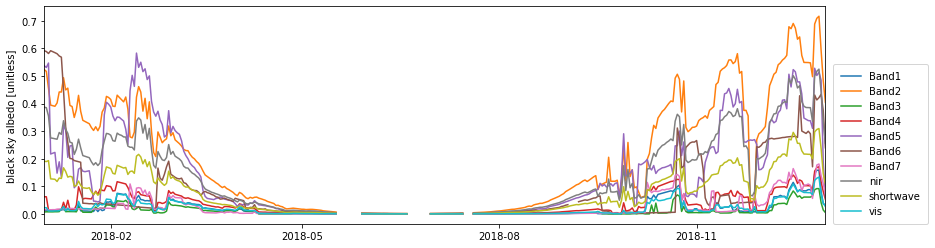

In [4]:
plt.figure(figsize=(14,4),)
for b in bands:
    p1, p2, p3 = (
        px[b].sel(param=0).squeeze(),
        px[b].sel(param=1).squeeze(),
        px[b].sel(param=2).squeeze())
    bsa = black(p1, p2, p3, sza)
    plt.plot(time, bsa, label=b.split("_")[-1]) 
plt.xlim(time[0].data, time[-1].data)       # set x limits
plt.legend(loc=(1.01, 0), borderpad=0.75)   # add legend
plt.ylabel("black sky albedo [unitless]")   # add ylabel 

#### White sky albedo

In [5]:
def white(par1, par2, par3):
    """ """
    iso, vol, geo = (1.000000, 0.189184, -1.377622)
    func = lambda p1, p2, p3: (
        p1*iso +                              # Isotropic
        p2*vol +                              # RossThick
        p3*geo )                              # LiSparseR 
    return(xr.apply_ufunc(func, par1, par2, par3))

Plot white sky albedo:

Text(0, 0.5, 'black sky albedo [unitless]')

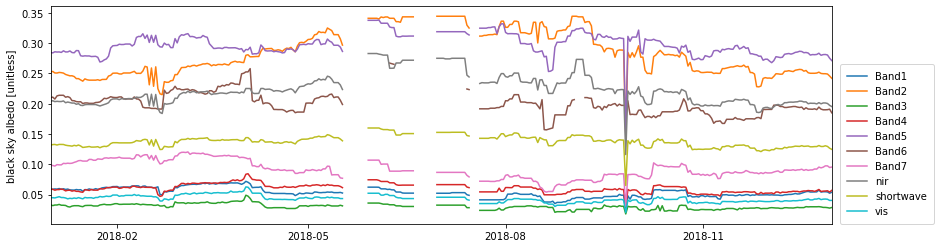

In [6]:
plt.figure(figsize=(14,4),)
for b in bands:
    p1, p2, p3 = (
        px[b].sel(param=0).squeeze(),
        px[b].sel(param=1).squeeze(),
        px[b].sel(param=2).squeeze())
    wsa = white(p1, p2, p3)
    plt.plot(time, wsa, label=b.split("_")[-1]) 
plt.xlim(time[0].data, time[-1].data)       # set x limits
plt.legend(loc=(1.01, 0), borderpad=0.75)   # add legend
plt.ylabel("black sky albedo [unitless]")   # add ylabel 

#### Blue sky albedo

In [7]:
def blue(wsa, bsa, lookup):
    """Vectorize albedo polynomials over two 3d arrays."""
    
    func = lambda white,black,lookup: (white*lookup) + (black*(1 - lookup))
    return(xr.apply_ufunc(func, wsa, bsa, lookup))

band = "BRDF_Albedo_Parameters_Band1"
sod = "0.02"    # solar optical depth 
lu = lookup(px[band], sza).reshape(sza.shape)
band_names = [v for v in px.variables if "Parameters" in v]

p1, p2, p3 = (
    px[band].sel(param=0).squeeze(),
    px[band].sel(param=1).squeeze(),
    px[band].sel(param=2).squeeze())

bsa = black(p1, p2, p3, sza)
wsa = white(p1, p2, p3)
alb = blue(bsa, wsa, lu)

alb

<xarray.DataArray 'BRDF_Albedo_Parameters_Band1' (time: 365)>
array([0.055699, 0.055696, 0.056309, ..., 0.056117, 0.05126 , 0.052371])
Coordinates:
  * time     (time) object 2018-01-01 00:00:00 ... 2018-12-31 00:00:00
    y        float64 3.216e+06
    x        float64 -8.033e+06
    lat      float64 28.92
    lon      float64 -82.54

/home/jack/Python/anaconda3/envs/jack/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
/home/jack/Python/anaconda3/envs/jack/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/jack/Python/anaconda3/envs/jack/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an 

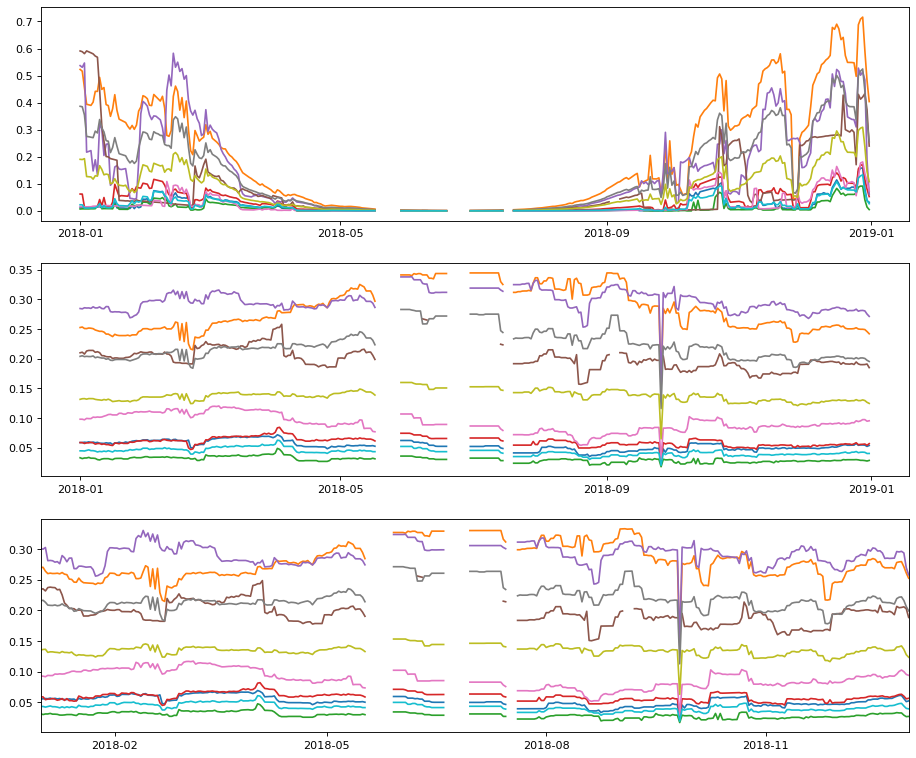

In [8]:
plt.figure(num=i, figsize=(14, 12), dpi=80, facecolor='w', edgecolor='k')

for i,b in enumerate(band_names): 
    
    band = px[b]
       
    par1, par2, par3 = [                    # get BRDF parameters
        band.sel(param=0).data.flatten(),   #  iso 
        band.sel(param=1).data.flatten(),   #  vol
        band.sel(param=2).data.flatten()]   #  geo
    
    bsa = black(par1, par2, par3, sza)
    wsa = white(par1, par2, par3)
    alb = blue(bsa, wsa, lu)
    
    plt.subplot(311); plt.plot(time, bsa, label=b.split("_")[-1]) 
    plt.subplot(312); plt.plot(time, wsa, label=b.split("_")[-1]) 
    plt.subplot(313); plt.plot(time, alb, label=b.split("_")[-1]) 
    plt.xlim(time[0].data, time[-1].data)       # set x limits
    #plt.legend(loc=(1.01, 0), borderpad=0.75)   # add legend
    #plt.ylabel("black sky albedo [unitless]")   # add ylabel 

```python
#band = Dropdown(options=band_names, value=band_names[0])
sza = FloatSlider(min=0, max=90, step=0.00001, value=45.00000)

plt.figure(
    num=None, 
    figsize=(15, 5), 
    dpi=80, 
    facecolor='w', 
    edgecolor='k')

b = px[band_names[0]]

def p(s):
    """ """
    plt.plot(px["time"], black(b,s))
    plt.show()

interact(p, s=sza);      #doy=, lat=); band=band, 
```

## Retrieve daily BRDF parameters 

From AppEEARS in this case... Details coming soon...

**Request the 2018 BRDF Parameters**: [data/MCD43A1-Florida-2018-request.json](data/MCD43A1-Florida-2018-request.json)

In [9]:
import json
with open("data/MCD43A1-Florida-2018-request.json", "r") as f:
    d = {k:v for k,v in json.load(f).items() if k!="params"}
    print(json.dumps(d, indent=2))

{
  "error": null,
  "status": "processing",
  "created": "2019-06-21T17:00:02.310429",
  "task_id": "f9ecaf4c-4eee-4236-beee-50fcfeb50963",
  "updated": "2019-06-21T18:07:07.768944",
  "user_id": "jjmcnelis@outlook.com",
  "retry_at": null,
  "task_name": "MCD43A1_Florida_2018",
  "task_type": "area",
  "api_version": null,
  "svc_version": "2.23",
  "web_version": "2.23",
  "expires_on": "2019-07-21T18:07:07.768944",
  "attempts": 1
}




### Not data files 
```
MCD43A1-Florida-2018-MCD43A1-006-metadata.xml 	ISO 19115 Metadata
MCD43A1-Florida-2018-granule-list.txt 			URLs for all source data
README.txt 									   Instructions/details about the request
MCD43A1-Florida-2018-request.json 				JSON to create a new request
```

The json [*MCD43A1-Florida-2018-request.json*](data/MCD43A1-Florida-2018-request.json) can be uploaded to AppEEARS to order an identical subset to the one used in the next notebook.

## Data quality

Reference: https://lpdaac.usgs.gov/products/mcd43a1v006/

Fortunately, MCD43 quality flags are as simple as they come (for MODIS):
```
Value 	Description
0 	    Processed; good quality (full BRDF inversions)
1 	    Processed; see other QA (magnitude BRDF inversions)
2 	    Processed; good quality (full BRDF inversions); Band 6 filled; dead or noisy detectors
3 	    Processed; see other QA (magnitude BRDF inversions); Band 6 filled; dead or noisy detectors
255 	Fill Value
```

### Ancillary files

<table>
    <col width="130">
    <col width="80">
    <thead>
        <tr>
            <th style="text-align: left;">File</th>
            <th style="text-align: left;">Description</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td><i>MCD43A1-006-BRDF-Albedo-Band-Mandatory-Quality-<b>BAND</b>-Statistics-QA.csv</i></td>
            <td>Statistics for quality layers</td>
        </tr>
         <tr>
            <td><i>MCD43A1-006-BRDF-Albedo-Band-Mandatory-Quality-<b>BAND</b>-lookup.csv</i></td>
            <td>Lookup for quality bits</td>
        </tr>
    </tbody>
</table>

```
MCD43A1-006-BRDF-Albedo-Band-Mandatory-Quality-Band1-Statistics-QA.csv	
MCD43A1-006-BRDF-Albedo-Band-Mandatory-Quality-Band1-lookup.csv		
MCD43A1-006-BRDF-Albedo-Band-Mandatory-Quality-Band2-Statistics-QA.csv	
MCD43A1-006-BRDF-Albedo-Band-Mandatory-Quality-Band2-lookup.csv		
MCD43A1-006-BRDF-Albedo-Band-Mandatory-Quality-Band3-Statistics-QA.csv	
MCD43A1-006-BRDF-Albedo-Band-Mandatory-Quality-Band3-lookup.csv		
MCD43A1-006-BRDF-Albedo-Band-Mandatory-Quality-Band4-Statistics-QA.csv	
MCD43A1-006-BRDF-Albedo-Band-Mandatory-Quality-Band4-lookup.csv		
MCD43A1-006-BRDF-Albedo-Band-Mandatory-Quality-Band5-Statistics-QA.csv	
MCD43A1-006-BRDF-Albedo-Band-Mandatory-Quality-Band5-lookup.csv		
MCD43A1-006-BRDF-Albedo-Band-Mandatory-Quality-Band6-Statistics-QA.csv	
MCD43A1-006-BRDF-Albedo-Band-Mandatory-Quality-Band6-lookup.csv		
MCD43A1-006-BRDF-Albedo-Band-Mandatory-Quality-Band7-Statistics-QA.csv	
MCD43A1-006-BRDF-Albedo-Band-Mandatory-Quality-Band7-lookup.csv		
MCD43A1-006-BRDF-Albedo-Band-Mandatory-Quality-nir-Statistics-QA.csv	
MCD43A1-006-BRDF-Albedo-Band-Mandatory-Quality-nir-lookup.csv			
MCD43A1-006-BRDF-Albedo-Band-Mandatory-Quality-shortwave-Statistics-QA.csv
MCD43A1-006-BRDF-Albedo-Band-Mandatory-Quality-shortwave-lookup.csv	
MCD43A1-006-BRDF-Albedo-Band-Mandatory-Quality-vis-Statistics-QA.csv		
MCD43A1-006-BRDF-Albedo-Band-Mandatory-Quality-vis-lookup.csv	
```

### Next


## Albedo

### User Guide
https://www.umb.edu/spectralmass/terra_aqua_modis/v006/mcd43a1_brdif_albedo_model_parameters_product

### Black sky albedo 

#### Constants

<table width="50%">
<tr>
<th>Term</td>
<th>Isotropic (iso)</th>
<th>RossThick (vol)</th>
<th>LiSparseR (geo)</th>
</tr>
<tr>
<td>g<sub>0</sub></td>
<td>&nbsp;1.0</td>
<td>-0.007574</td>
<td>-1.284909</td>
</tr>
<tr>
<td>g<sub>1</sub></td>
<td>&nbsp;0.0</td>
<td>-0.070987</td>
<td>-0.166314</td>
</tr>
<tr>
<td>g<sub>2</sub></td>
<td>&nbsp;0.0</td>
<td>&nbsp; &nbsp;0.307588</td>
<td>&nbsp; &nbsp;0.041840</td>
</tr>
</table>


#### Equation
![bsa](https://www.umb.edu/editor_uploads/images/csm_eeos/images/eqn2small.jpg)

### White sky albedo

#### Constants

<table width="50%">
<tr>
<th>Term</td>
<th>Isotropic (iso)</th>
<th>RossThick (vol)</th>
<th>LiSparseR (geo)</th>
</tr>
<tr>
<td>White-sky<br>
integral <i>g</i></td>
<td>&nbsp;1.0</td>
<td>&nbsp;0.189184</td>
<td>-1.377622</td>
</tr>
</table>



#### Equation
![wsa](https://www.umb.edu/editor_uploads/images/csm_eeos/images/eqn3small.jpg)


### Blue sky Albedo

Continue...

## Calculate solar angles at local noon

These calculations were harvested from: 
http://holbert.faculty.asu.edu/eee463/SolarCalcs.pdf

The ORNL DAAC uses an executable that is probably ten years old and we don't have the source code! So, the longest step in this process was determining which equations would yield the same result as that executable. Very frustrating. Nonetheless, I'm very confident in the result. 

Import `math.radians` and `math.cos` for the calculation:

In [10]:
from math import radians, cos

### Declination angle

https://sciencing.com/calculate-suns-declination-6904335.html

In [11]:
doy = 166                  # day of the year    
diy = 365                  # number of days in the year
deg_rot_per_day = 360/diy  # degree of rotation per day
abs_max_decl = 23.44       # absolute |maximum declination angle|

deg_rot_per_day

0.9863013698630136

Get cosine of x and multiple it by the negative of the max lat (axial tilt, -23.44) to get solar declination in degrees:

In [12]:
decl = cos(radians((doy+10)*deg_rot_per_day))*-abs_max_decl
decl

23.293419845424015

### Solar zenith angle
The sum of the solar zenith angle and the solar altitude angle equal 90 degrees. In the northern hemisphere, get the solar altitude angle by subtracting latitude from 90 and summing with the declination angle. 

Compute SZA at 35 degrees latitude on day of the year 166. First get the declination:

In [13]:
lat, doy, ndoy = 35., 166., 365
decl = cos(radians((doy+10)*(360/ndoy)))*-23.45

decl

23.303357311228375

Now get solar altitude angle:

In [14]:
solar_alt = 90. - lat + decl

solar_alt

78.30335731122838

Now subtract solar altitude from 90 to get the solar zenith angle:

In [15]:
solar_zen = 90. - solar_alt

solar_zen

11.696642688771618

As a function:

In [16]:
def get_solar_zenith(latitude, doy, ndoy=365):
    """ """
    declination = cos(radians((doy+10)*(360/ndoy)))*-23.45
    solar_altitude = 90 - latitude + declination
    solar_zenith = 90 - solar_altitude
    return(solar_zenith)
    
get_solar_zenith(35, 166)

11.696642688771618

The result matches the output from the solar zenith calculator used by ORNL DAAC:
```shell
[jnd@daacmodis1 plug_1]$ ./local_szn.1.exe 35 166
lat 35.0000000 day 166 lzsn 11.696643
```